In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import iglob
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns

In [2]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['legend.markerscale'] = 2
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.dpi'] = 100

sns.set_style('ticks')
sns.set_palette('Set1')

# Look at some basic qc information about the experiments

In [3]:
qcs = iglob('mSp_scATAC-seq/qc_metrics/*.txt')

dfs = []
for qc in qcs:
    dfs.append(pd.read_table(qc, index_col=0))

plate_qc = pd.concat(dfs, axis=1)
plate_qc['plate'] = plate_qc.index.str.extract('mSp_(.*)_.*', expand=False)

# two batches (biological replicates)
# rep1 to rep4 are from one mouse
# rep5 to rep11 are from another mouse
batches = {}
for i in range(1,5):
    batches['rep{}'.format(i)] = 'Sp#1 (n=960)'
for i in range(5,12):
    batches['rep{}'.format(i)] = 'Sp#2 (n=2688)'

plate_qc['batch'] = plate_qc.plate.replace(batches) 

sort_idx = plate_qc.index.sort_values()
plate_qc =  plate_qc.loc[sort_idx]

plate_qc.head()

,frip,uniq_frags,mt_content,sequencing_depth,dup_level,frac_open,mapping_rate,plate,batch
cell,,,,,,,,,
mSp_rep10_001,0.726419,34703.0,0.008089,706791,0.946339,0.177978,97.05,rep10,Sp#2 (n=2688)
mSp_rep10_002,0.670139,47380.0,0.021640,1055503,0.949220,0.216714,96.44,rep10,Sp#2 (n=2688)
mSp_rep10_003,0.744450,21556.0,0.005031,464232,0.949138,0.124075,96.63,rep10,Sp#2 (n=2688)
mSp_rep10_004,0.682887,33741.0,0.017701,719629,0.947677,0.178362,96.82,rep10,Sp#2 (n=2688)
mSp_rep10_005,0.668207,43846.0,0.011364,879974,0.945384,0.204391,97.06,rep10,Sp#2 (n=2688)


In [4]:
plate_qc.median()

frip                     0.724165
uniq_frags           30727.000000
mt_content               0.018261
sequencing_depth    643734.000000
dup_level                0.946167
frac_open                0.166699
mapping_rate            97.050000
dtype: float64

In [5]:
plate_qc.groupby('plate').median()

,frip,uniq_frags,mt_content,sequencing_depth,dup_level,frac_open,mapping_rate
plate,,,,,,,
rep1,0.739804,26334.5,0.024070,613945.5,0.953395,0.149041,97.310
rep10,0.732649,30715.5,0.018710,613522.0,0.944155,0.167512,96.890
rep11,0.720001,33503.0,0.016635,721892.5,0.949515,0.177395,97.300
rep2,0.719500,29019.5,0.020952,1143367.5,0.972433,0.159602,97.225
rep3,0.716885,30389.0,0.020108,771192.0,0.957338,0.163740,97.100
rep4,0.727318,30139.0,0.020314,719885.5,0.954211,0.163137,97.170
rep5,0.714813,32436.0,0.015515,593435.5,0.940420,0.174243,97.335
rep6,0.723693,20976.5,0.021978,539171.5,0.955234,0.124305,96.320
rep7,0.734233,29098.5,0.018501,616298.0,0.947172,0.159704,96.840


In [6]:
plate_qc.groupby('batch').median()

,frip,uniq_frags,mt_content,sequencing_depth,dup_level,frac_open,mapping_rate
batch,,,,,,,
Sp#1 (n=960),0.724785,29679.5,0.020665,745627,0.956036,0.161069,97.16
Sp#2 (n=2688),0.724142,31193.0,0.017594,614981,0.943526,0.168569,97.01


In [7]:
empty_cells = ['mSp_rep1_096', 'mSp_rep2_096',
               'mSp_rep3_366', 'mSp_rep3_372', 'mSp_rep3_378', 'mSp_rep3_384',
               'mSp_rep4_366', 'mSp_rep4_372', 'mSp_rep4_378', 'mSp_rep4_384']
empty_cells.extend(['mSp_rep{}_384'.format(i) for i in range(5,12)])

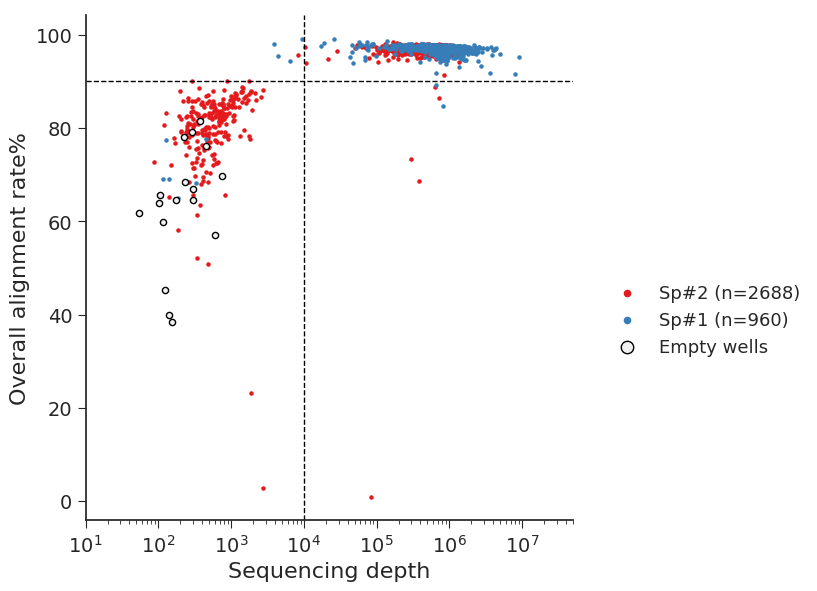

In [28]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', size=6)
g.map(plt.scatter, 'sequencing_depth', 'mapping_rate', s=5)
g.ax.set_xscale('log')
g.ax.set_xlim(10, 5e7)

g.ax.scatter(plate_qc.loc[empty_cells, 'sequencing_depth'],
             plate_qc.loc[empty_cells, 'mapping_rate'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1.5, .5])
g.ax.axhline(y=90, xmin=0, xmax=1, ls='dashed', c='k', lw=1.)
g.ax.axvline(x=1e4, ymin=0, ymax=1, ls='dashed', c='k', lw=1.)

g.ax.set_xlabel('Sequencing depth')
g.ax.set_ylabel('Overall alignment rate%')

plt.savefig('figures/qc_sequencing_depth_vs_mapping_rate.pdf',
            bbox_inches='tight', transparent=True)

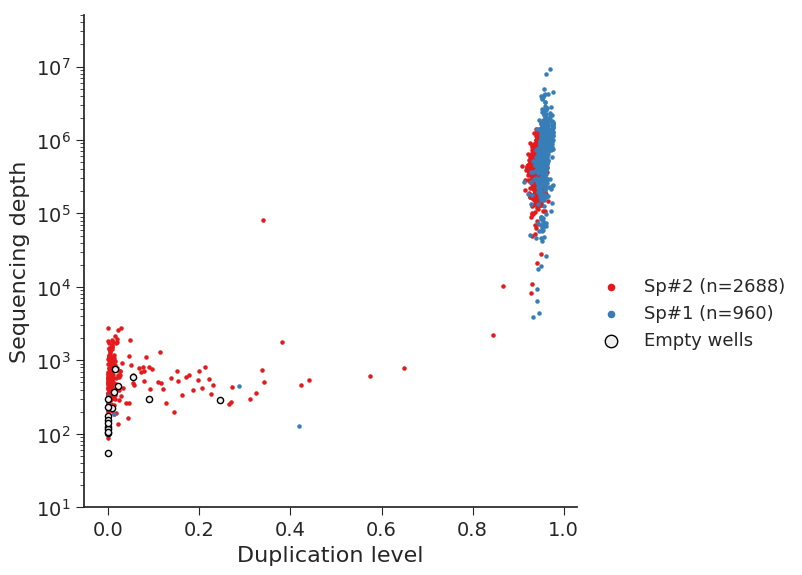

In [20]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', size=6)
g.map(plt.scatter, 'dup_level', 'sequencing_depth', s=5)
g.ax.set_yscale('log')
g.ax.set_ylim(10, 5e7)

g.ax.scatter(plate_qc.loc[empty_cells, 'dup_level'],
             plate_qc.loc[empty_cells, 'sequencing_depth'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1., .5])

g.ax.set_xlabel('Duplication level')
g.ax.set_ylabel('Sequencing depth')

plt.savefig('figures/qc_sequencing_depth_vs_duplication_level.pdf',
            bbox_inches='tight', transparent=True)

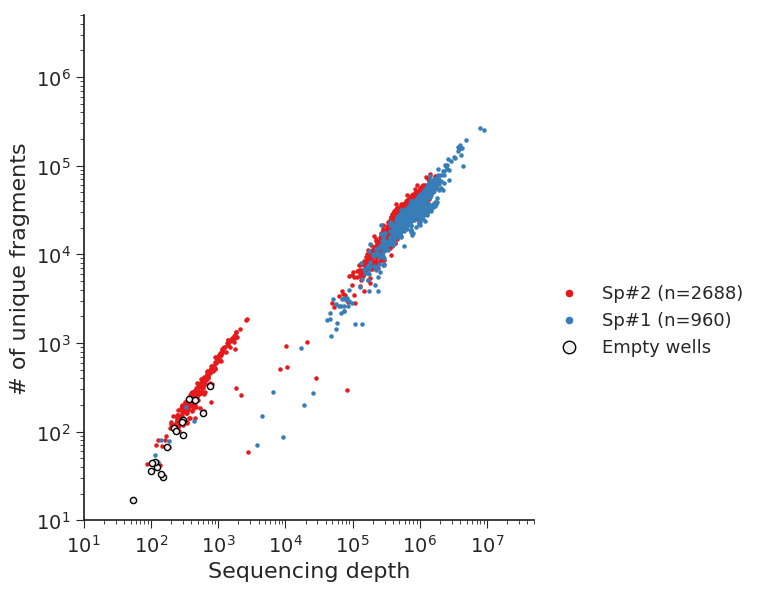

In [22]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', size=6)
g.map(plt.scatter, 'sequencing_depth', 'uniq_frags', s=5)
g.ax.set_xscale('log')
g.ax.set_yscale('log')
g.ax.set_xlim(10, 5e7)
g.ax.set_ylim(10, 5e6)

g.ax.scatter(plate_qc.loc[empty_cells, 'sequencing_depth'],
             plate_qc.loc[empty_cells, 'uniq_frags'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1.5, .5])

g.ax.set_xlabel('Sequencing depth')
g.ax.set_ylabel('# of unique fragments')

plt.savefig('figures/qc_sequencing_depth_vs_uniq_frags.pdf',
            bbox_inches='tight', transparent=True)

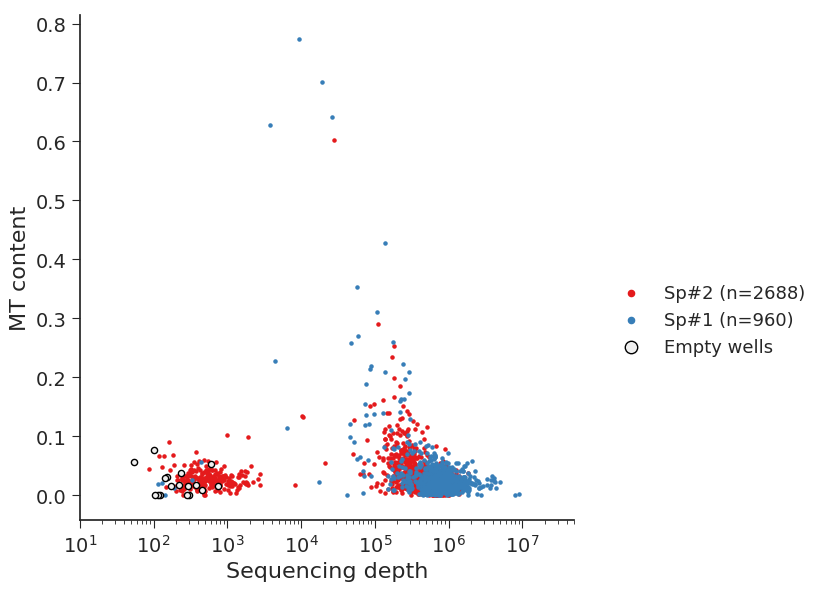

In [23]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', size=6)
g.map(plt.scatter, 'sequencing_depth', 'mt_content', s=5)
g.ax.set_xscale('log')
g.ax.set_xlim(10, 5e7)

g.ax.scatter(plate_qc.loc[empty_cells, 'sequencing_depth'],
             plate_qc.loc[empty_cells, 'mt_content'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1.5, .5])

g.ax.set_xlabel('Sequencing depth')
g.ax.set_ylabel('MT content')

plt.savefig('figures/qc_sequencing_depth_vs_mt_content.pdf',
            bbox_inches='tight', transparent=True)

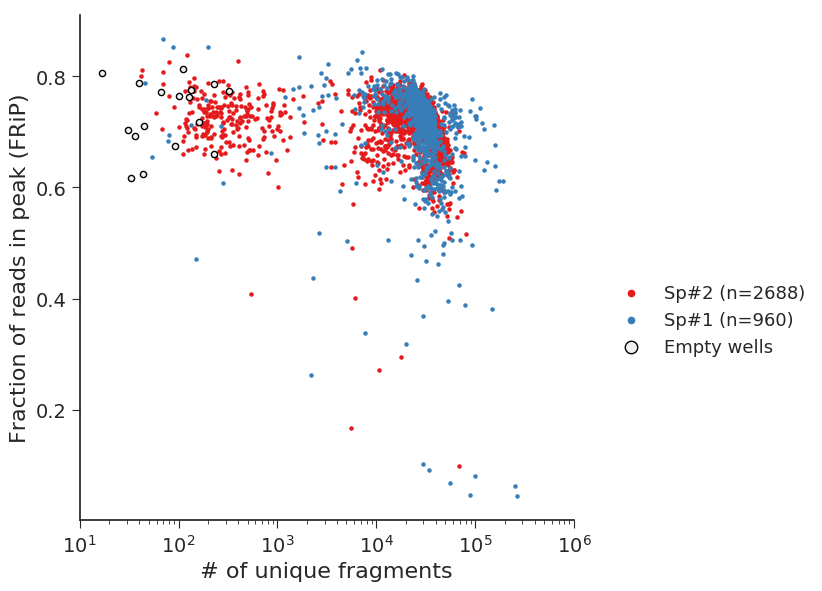

In [25]:
g = sns.FacetGrid(plate_qc.drop(labels=empty_cells), hue='batch', size=6, palette='Set1')
g.map(plt.scatter, 'uniq_frags', 'frip', s=5)
g.ax.set_xscale('log')
g.ax.set_xlim(10, 1e6)

g.ax.scatter(plate_qc.loc[empty_cells, 'uniq_frags'],
             plate_qc.loc[empty_cells, 'frip'],
             label='Empty wells', c='#f0f0f0',
             s=20, edgecolors='k')

g.ax.legend(bbox_to_anchor=[1.5, .5])

g.ax.set_xlabel('# of unique fragments')
g.ax.set_ylabel('Fraction of reads in peak (FRiP)')

plt.savefig('figures/uniq_frags_vs_frip.pdf',
            bbox_inches='tight', transparent=True)

Text(0,0.5,'Frequency (%)')

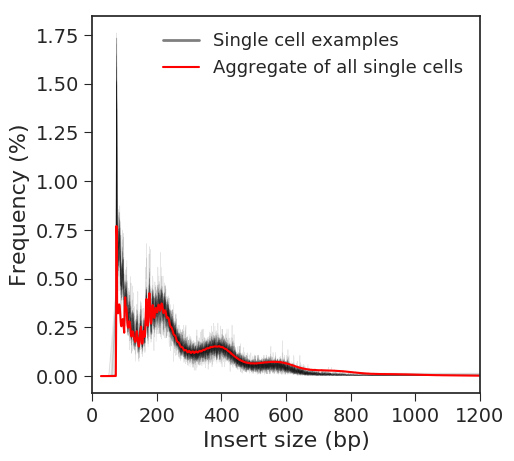

In [17]:
# look at the isize distritubtion
fig, ax = plt.subplots(figsize=(5,5))

# read the isize of aggregated data
merged = pd.read_table('mSp_scATAC-seq/aggregate/f2q30_merged_pmd_isize.hist',
                       sep=' ', header=None, names=['count', 'size'])

# read 24 single cells to plot
examples = ['mSp_scATAC-seq/rep9/isize_hist/mSp_rep9_{:0>3}_isize.hist'\
            .format(i) for i in range(1,24)]

scs = []
for i in examples:
    scs.append(pd.read_table(i, sep=' ', header=None, names=['count', 'size']))

ax.plot(scs[0]['size'],
        scs[0]['count']/scs[0]['count'].sum() * 100,
        'k-', label='Single cell examples', lw=.5, alpha=.1)

for sc in scs[1:]:
    ax.plot(sc['size'],
            sc['count']/sc['count'].sum() * 100,
            'k-', lw=.5, alpha=.1, label='')

ax.plot(merged['size'],
        merged['count']/merged['count'].sum() * 100,
        'r-', lw=1.5, label='Aggregate of all single cells')

lg = ax.legend()
lg_lines = lg.get_lines()
lg_lines[0].set_linewidth(2)
lg_lines[0].set_alpha(.5)

ax.set_xlim(0,1200)
ax.set_xlabel('Insert size (bp)')
ax.set_ylabel('Frequency (%)', )

# plt.savefig('figures/fragment_size_distribution.pdf',
#             bbox_inches='tight', transparent=True)

Text(0,0.5,'Tag density')

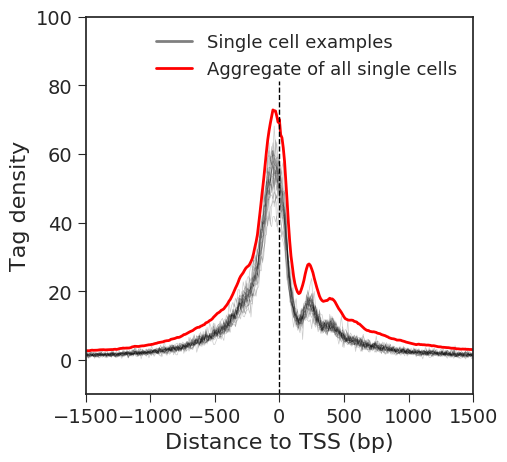

In [14]:
# look at the read distribution around TSS

# read output from homer
den = pd.read_table('mSp_scATAC-seq/tagdensity_around_mm10_tss_by_homer_annotatepeaks.txt',
                    skiprows=1, header=None, usecols = range(1, 76, 3),
                    names = ['aggregate'] + ['sc_{}'.format(i) for i in range(1,25)])

fig, ax = plt.subplots(figsize=(5,5))

x = np.linspace(-1500, 1500, num=301)

ax.plot(x, den['sc_1'], 'k-', label='Single cell examples', lw=.5, alpha=.2)
for sc in den.columns[2:]:
    ax.plot(x, den[sc], 'k-', lw=.5, alpha=.2, label='')

ax.plot(x, den['aggregate'], 'r-', lw=2, label='Aggregate of all single cells')

lg = ax.legend()
lg_lines = lg.get_lines()
lg_lines[0].set_linewidth(2)
lg_lines[0].set_alpha(.5)

ax.axvline(x=0, ymin=0, ymax=.83, ls='dashed', c='k', lw=1)
ax.set_xlim(-1500,1500)
ax.set_ylim(-10, 100)

ax.set_xlabel('Distance to TSS (bp)')
ax.set_ylabel('Tag density')

# plt.savefig('figures/tss_plot.pdf', bbox_inches='tight', transparent=True)

In [17]:
# # output bad cells

bad_cells = plate_qc[(plate_qc.sequencing_depth < 1e4) | (plate_qc.mapping_rate < 90)]
# bad_cells.to_csv('mSp_scATAC-seq/qc_bad_cells.csv')

In [18]:
# plate_qc.to_csv('mSp_scATAC-seq/qc_all.csv')

In [19]:
bad_cells.shape[0]

262

# Comparing downsampled plate scATAC-seq with C1 scATAC-seq

In [20]:
# it seems the sequencing depth of C1 scATAC is about 20% of our plate scATAC
# so here 20% of downsampled of our data is used
qcs = iglob('cmp_to_c1/qc_metrics/*.txt')

dfs = []
for qc in qcs:
    dfs.append(pd.read_table(qc, index_col=0))

ds_plate_qc = pd.concat(dfs, axis=1)
ds_plate_qc['plate'] = ds_plate_qc.index.str.extract('mSp_(.*)_.*', expand=False)
ds_plate_qc['batch'] = ds_plate_qc.plate.replace(batches) 

ds_plate_qc.head(2)

,frip,uniq_frags,mt_content,sequencing_depth,dup_level,frac_open,mapping_rate,plate,batch
cell,,,,,,,,,
mSp_rep10_001,0.737430,29033.0,0.008944,140871,0.774630,0.165933,97.05,rep10,Sp#2 (n=2688)
mSp_rep10_002,0.676146,39919.0,0.023460,210428,0.784939,0.202622,96.44,rep10,Sp#2 (n=2688)


In [21]:
ds_plate_qc.median()

frip                     0.733437
uniq_frags           26448.000000
mt_content               0.019173
sequencing_depth    128320.000000
dup_level                0.770263
frac_open                0.156992
mapping_rate            97.050000
dtype: float64

In [22]:
qcs = iglob('c1_scATAC/qc_metrics/*.txt')

dfs = []
for qc in qcs:
    dfs.append(pd.read_table(qc, index_col=0))

c1_qc = pd.concat(dfs, axis=1)

annotation = pd.concat([pd.read_table('c1_scATAC/PRJNA274006.txt'),
                        pd.read_table('c1_scATAC/PRJNA299657.txt')])

c1_qc.rename(index=dict(annotation[['run_accession', 'sample_title']].values),
             inplace=True)
c1_qc['cells'] = c1_qc.index.str.split('-').str[1]
c1_qc['batch'] = c1_qc.index.str.extract('singles-(.*)-.*-.*', expand=False)

# one sample is not captured with str.extract
c1_qc['batch'].fillna('BM1077-LMPP', inplace=True)

# add number of cells into batch name
n = c1_qc['batch'].value_counts()
rebatch = {}
for i in n.index:
    rebatch[i] = str(i) + ' (n=%s)' % str(n[i])
c1_qc.replace({'batch' : rebatch}, inplace=True)

In [23]:
c1_qc.median()

frip                     0.554559
uniq_frags            8647.500000
mt_content               0.536170
sequencing_depth    134669.000000
dup_level                0.612317
frac_open                0.067088
mapping_rate            69.775000
dtype: float64

In [24]:
c1_qc.batch.value_counts()

SU070 (n=192)          192
K562-rep2 (n=192)      192
K562-rep1 (n=192)      192
K562-rep3 (n=192)      192
GM-rep3 (n=96)          96
K562-CDKi (n=96)        96
K562-Imat1hr (n=96)     96
PB1022-mono (n=96)      96
HL60 (n=96)             96
GM-TNFa6h (n=96)        96
SU353-LSC (n=96)        96
GM-rep2 (n=96)          96
TF1 (n=96)              96
mESC (n=96)             96
EML (n=96)              96
GM-rep4 (n=96)          96
H1ESC (n=96)            96
BJ (n=96)               96
SU353-Blast (n=96)      96
K562-JNKi (n=96)        96
BM1077-LMPP (n=96)      96
GM-rep1 (n=96)          96
Name: batch, dtype: int64

In [25]:
sample_info = pd.concat([ds_plate_qc, c1_qc])
sample_info.head(2)

,batch,cells,dup_level,frac_open,frip,mapping_rate,mt_content,plate,sequencing_depth,uniq_frags
cell,,,,,,,,,,
mSp_rep10_001,Sp#2 (n=2688),NaN,0.774630,0.165933,0.737430,97.05,0.008944,rep10,140871,29033.0
mSp_rep10_002,Sp#2 (n=2688),NaN,0.784939,0.202622,0.676146,96.44,0.023460,rep10,210428,39919.0


In [26]:
median_info = sample_info.groupby("batch").median()

# call drop_duplicates on sample_info to re-order the experiments
median_info = median_info.loc[sample_info.batch.drop_duplicates().values,]
reorder = [1, 0] + list(range(2,24))
median_info = median_info.iloc[reorder,]
median_info.head(2)

,dup_level,frac_open,frip,mapping_rate,mt_content,sequencing_depth,uniq_frags
batch,,,,,,,
Sp#1 (n=960),0.802241,0.155578,0.733971,97.165,0.021380,148639.0,26593.5
Sp#2 (n=2688),0.760225,0.157396,0.733331,97.010,0.018632,122675.5,26426.5


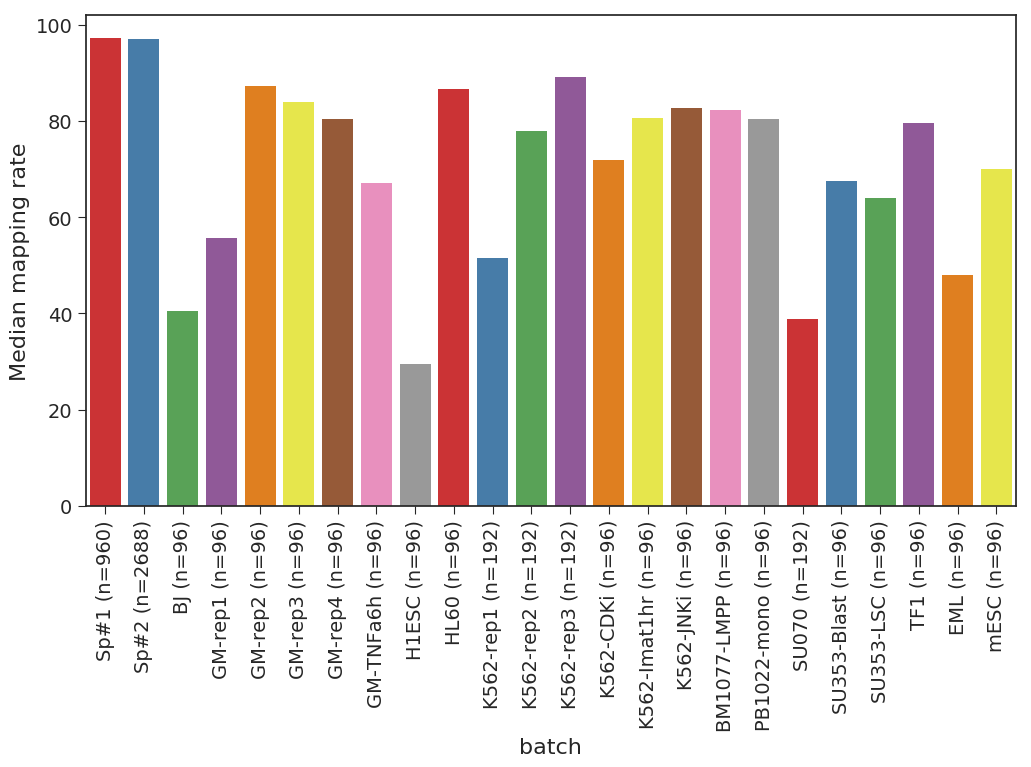

In [27]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(x=median_info.index, y="mapping_rate", data=median_info, palette="Set1", ax=ax)
ax.set_ylabel("Median mapping rate")
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig("figures/compare_mapping_rate.pdf", bbox_inches="tight", transparent=True)

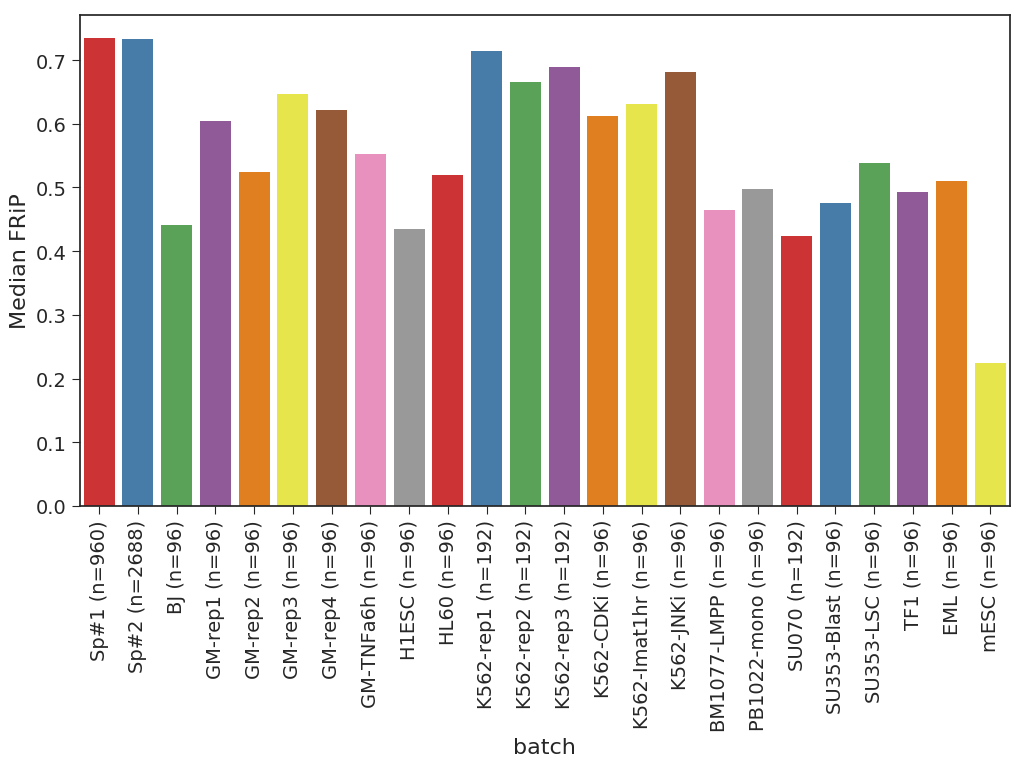

In [28]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(x=median_info.index, y='frip', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median FRiP')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_frip.pdf', bbox_inches='tight', transparent=True)

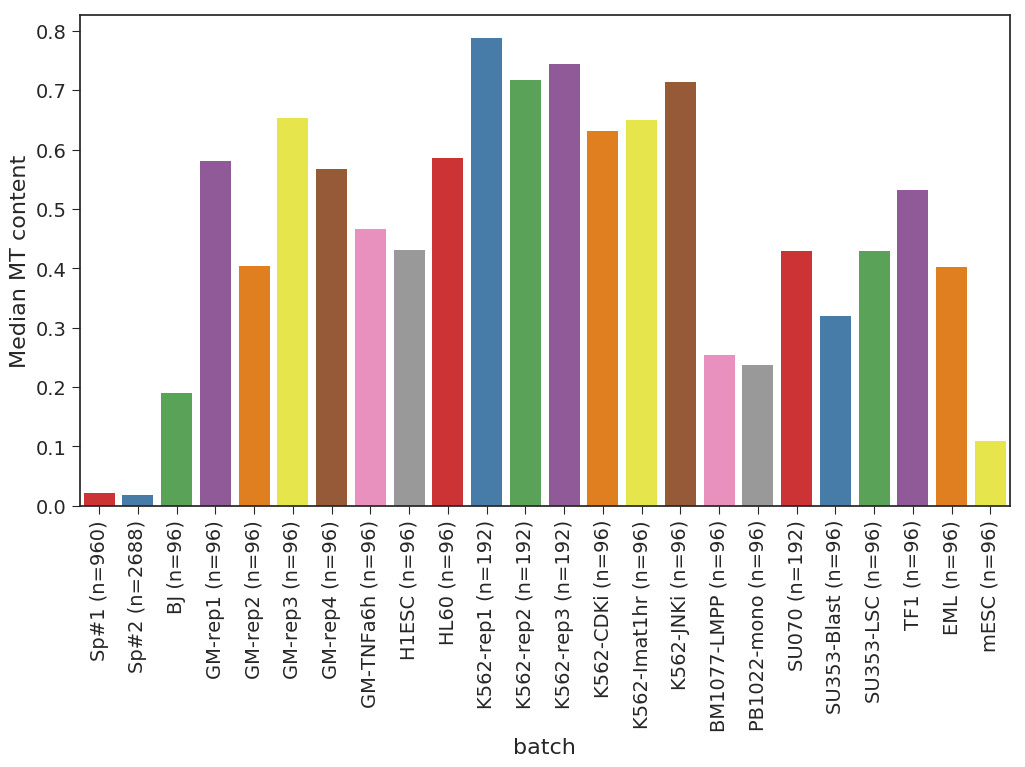

In [29]:
# this is not a entirely fair comparison since we used digitonin in this study
# while the C1 studies were using NP-40

fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(x=median_info.index, y='mt_content', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median MT content')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_mt_content.pdf', bbox_inches='tight', transparent=True)

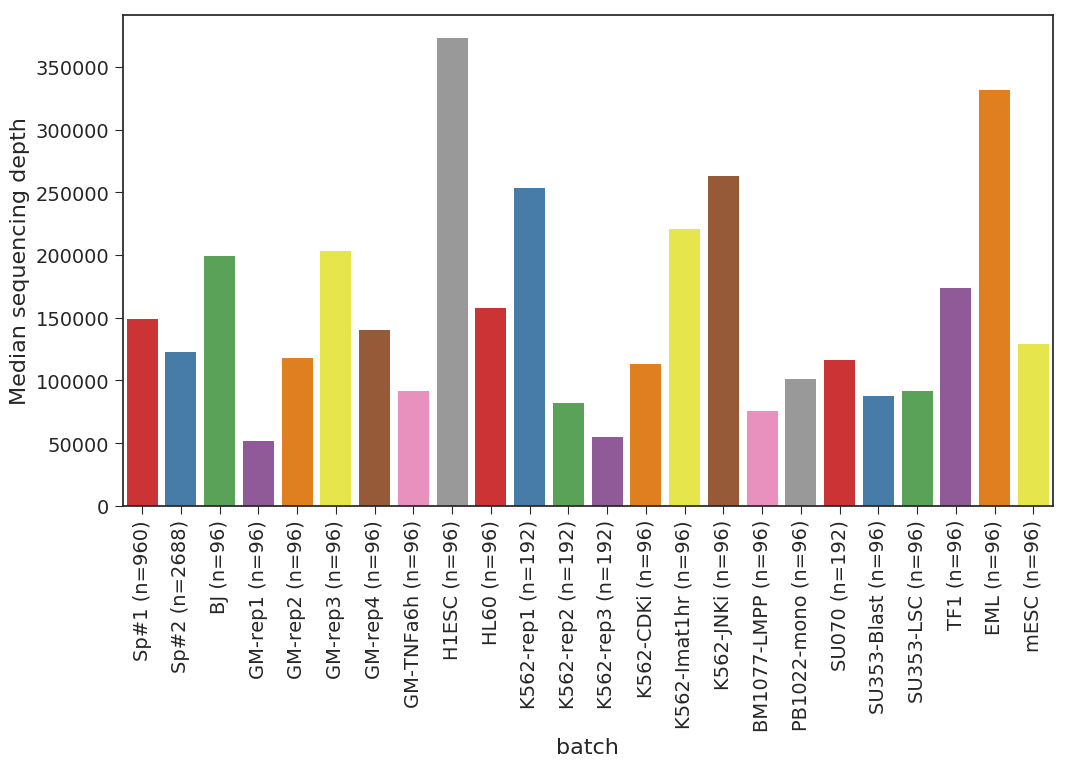

In [30]:
fig, ax = plt.subplots(figsize=(12, 6.5))

sns.barplot(x=median_info.index, y='sequencing_depth', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median sequencing depth')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_sequencing_depth.pdf', bbox_inches='tight', transparent=True)

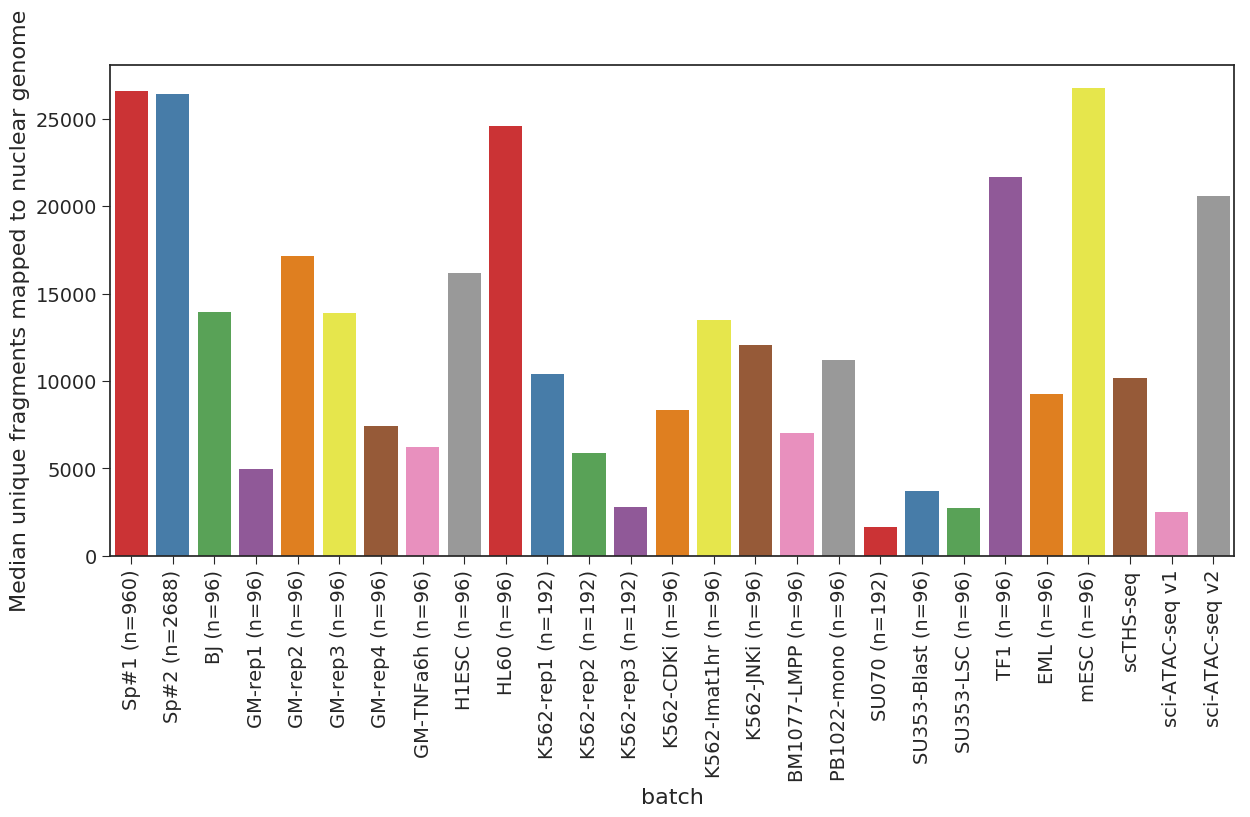

In [31]:
# add information of scTHS-seq (Lake et al. 2018 Nature Biotechnology 36, 70–80.)
# & sci-ATAC-seq v1 (Cusanovich et al. 2015 Science 348: 910–914.)
# & sci-ATAC-seq v2 (Cusanovich et al. 2017 doi: https://doi.org/10.1101/166066)

median_info.loc['scTHS-seq','uniq_frags'] = 10168
median_info.loc['sci-ATAC-seq v1', 'uniq_frags'] = 2503
median_info.loc['sci-ATAC-seq v2', 'uniq_frags'] = 20587

fig, ax = plt.subplots(figsize=(14.5, 6.5))

sns.barplot(x=median_info.index, y='uniq_frags', data=median_info, palette='Set1', ax=ax)
ax.set_ylabel('Median unique fragments mapped to nuclear genome')
for xt in ax.get_xticklabels():
    xt.set_rotation(90)
# plt.savefig('figures/compare_uniq_frags.pdf', bbox_inches='tight', transparent=True)

# Downsampling analysis to look at # of unique fragments

In [30]:
!ls downsampling/*/qc_metrics/uniq_frags.txt

downsampling/0.1/qc_metrics/uniq_frags.txt
downsampling/0.2/qc_metrics/uniq_frags.txt
downsampling/0.3/qc_metrics/uniq_frags.txt
downsampling/0.4/qc_metrics/uniq_frags.txt
downsampling/0.5/qc_metrics/uniq_frags.txt
downsampling/0.6/qc_metrics/uniq_frags.txt
downsampling/0.7/qc_metrics/uniq_frags.txt
downsampling/0.8/qc_metrics/uniq_frags.txt
downsampling/0.9/qc_metrics/uniq_frags.txt


In [31]:
f = list(iglob('downsampling/*/qc_metrics/uniq_frags.txt'))
f.sort()

dfs = []

for i in f:
    frac = i.split('/')[1]
    dfs.append(pd.read_table(i, header=None, skiprows=1, names=['cell', frac],
                             index_col='cell'))
ufrags = pd.concat(dfs, axis=1)
ufrags['1.0'] = plate_qc.loc[:, 'uniq_frags']
ufrags.head(2)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
cell,,,,,,,,,,
mSp_rep3_001,28539.0,31470.0,32380.0,32885.0,33233.0,33503.0,33734.0,33956.0,34136.0,34304.0
mSp_rep3_002,5353.0,6004.0,6200.0,6324.0,6413.0,6483.0,6536.0,6582.0,6615.0,6659.0


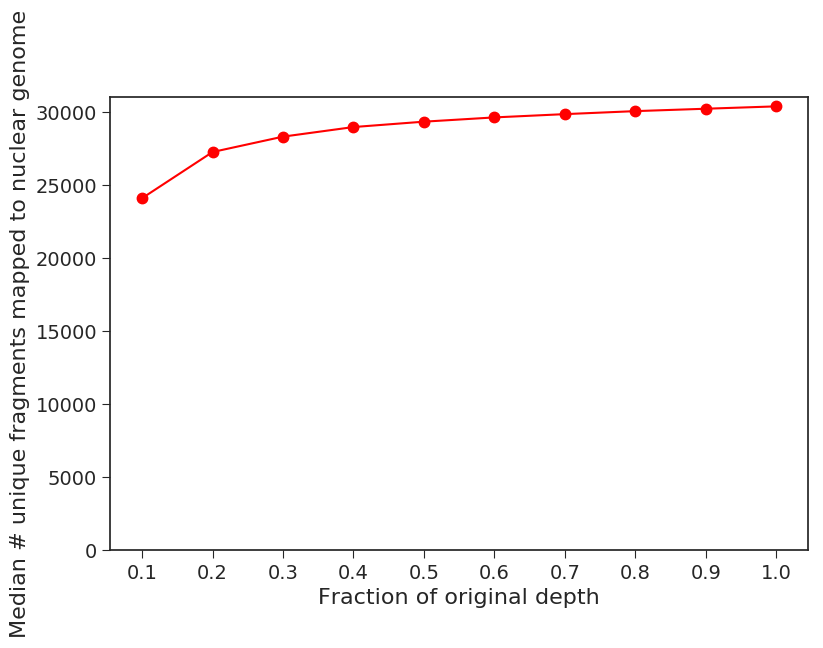

In [32]:
plt.figure(figsize=(9, 6))
plt.plot(ufrags.columns.astype(float), ufrags.median(), 'r.-', ms=15)
plt.xticks(ufrags.columns.astype(float), ufrags.columns.values)
plt.ylim(0, 31000)
plt.xlabel('Fraction of original depth')
plt.ylabel('Median # unique fragments mapped to nuclear genome')

plt.savefig('figures/subsampling_unique_fragments_median.pdf',
            bbox_inches='tight', transparent=True)

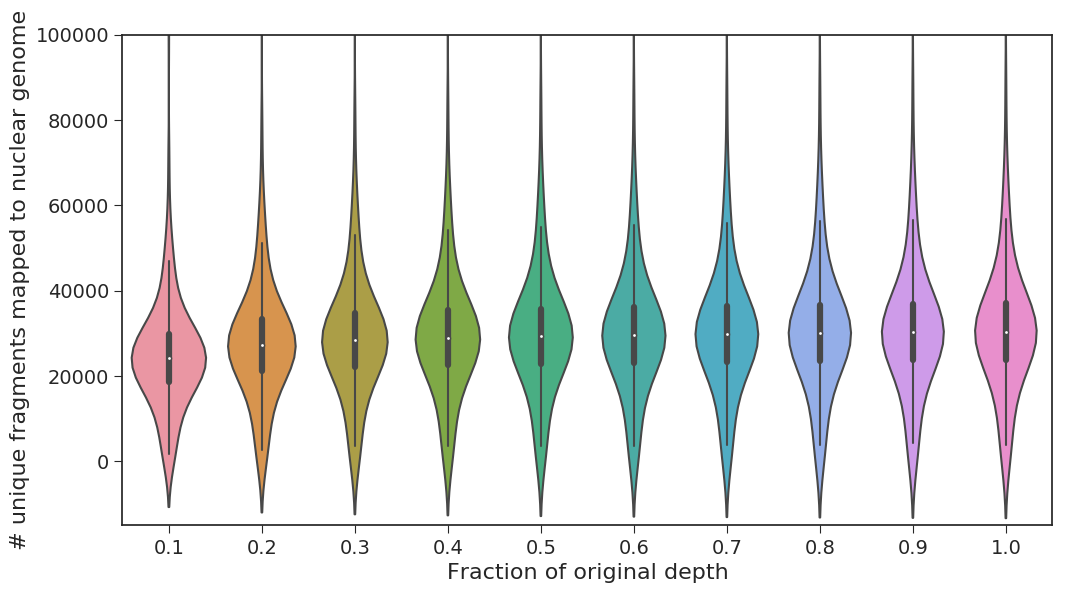

In [33]:
violin_data = ufrags.melt(value_vars=ufrags.columns)

fig, ax = plt.subplots(figsize=(12, 6.5))

sns.violinplot(x='variable', y='value', data=violin_data, ax=ax)
ax.set_xlabel('Fraction of original depth')
ax.set_ylabel('# unique fragments mapped to nuclear genome')
ax.set_ylim(-15000, 100000)

plt.savefig('figures/subsampling_unique_fragments_violin.pdf',
            bbox_inches='tight', transparent=True)

# Perform some basic exploratory analysis

In [34]:
from scipy.io import mmread

count = mmread('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.mtx')
idxs = [i.strip() for i in open('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.rownames')]
cols = [i.strip() for i in open('cmp_to_immgen/mSp_scATAC_count_matrix_over_all.colnames')]

sc_count = pd.DataFrame(data=count.toarray(),
                        index=idxs,
                        columns=cols)

sc_count.drop(labels=bad_cells.index, axis=1, inplace=True)

# binarise the data
bin_sc_count = sc_count.where(sc_count < 1, 1)
sc_count = sc_count.loc[bin_sc_count.index, bin_sc_count.columns]
bin_sc_count.shape

(127856, 3386)

In [35]:
bin_sc_count.head(2)

,mSp_rep7_276,mSp_rep7_267,mSp_rep7_325,mSp_rep7_270,mSp_rep7_092,mSp_rep7_291,mSp_rep7_196,mSp_rep7_347,mSp_rep7_141,mSp_rep7_079,...,mSp_rep6_216,mSp_rep6_110,mSp_rep6_353,mSp_rep6_174,mSp_rep6_255,mSp_rep6_250,mSp_rep6_280,mSp_rep6_046,mSp_rep6_302,mSp_rep6_019
spleen_uPk_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spleen_uPk_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# perform Latent Semantic Indexing Analysis

# get TF-IDF matrix
tfidf = TfidfTransformer(norm='l2', sublinear_tf=True)
normed_count = tfidf.fit_transform(bin_sc_count.T)

# perform SVD on the sparse matrix
lsi = TruncatedSVD(n_components=20, random_state=42)
lsi_r = lsi.fit_transform(normed_count)

lsi.explained_variance_ratio_

array([0.00615814, 0.03146934, 0.00830842, 0.00660499, 0.00400276,
       0.00236671, 0.00210679, 0.00187625, 0.00165964, 0.0012722 ,
       0.00110199, 0.00104292, 0.0008829 , 0.00078783, 0.00077141,
       0.00070846, 0.00066163, 0.00064193, 0.0005851 , 0.00056336])

In [37]:
plate_qc = plate_qc.loc[bin_sc_count.columns]
for i in range(3):
    plate_qc['LSI Dimension {}'.format(i+1)] = lsi_r[:, i]
plate_qc = plate_qc.loc[sorted(plate_qc.index)]

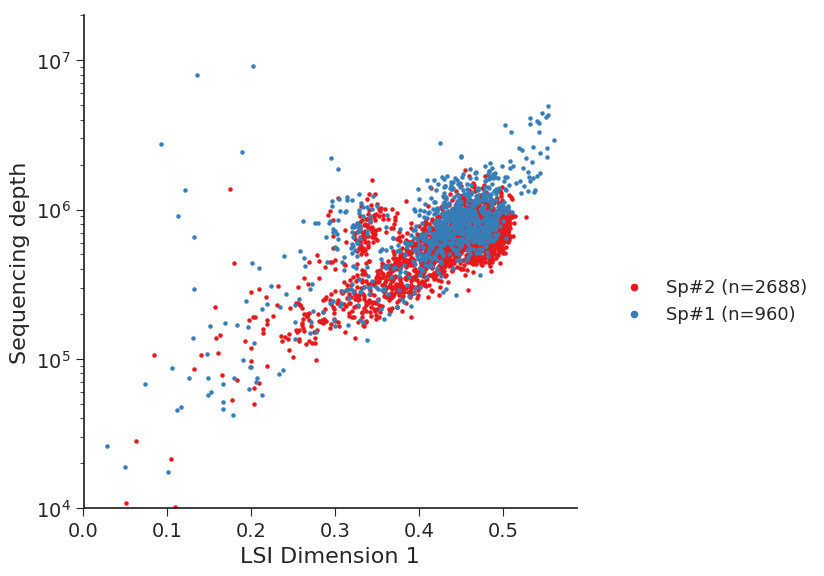

In [38]:
# have a look the first dimension and the sequencing depth

g = sns.FacetGrid(plate_qc, hue='batch', size=6)
g.map(plt.scatter, 'LSI Dimension 1', 'sequencing_depth', s=5)
g.ax.legend(bbox_to_anchor=[1.5, .5])
g.ax.set_yscale('log')
g.ax.set_ylim(1e4, 2e7)
g.ax.set_ylabel('Sequencing depth')

plt.savefig('figures/LSI_1st_dimension_vs_sequencing_depth.pdf',
            bbox_inches='tight', transparent=True)

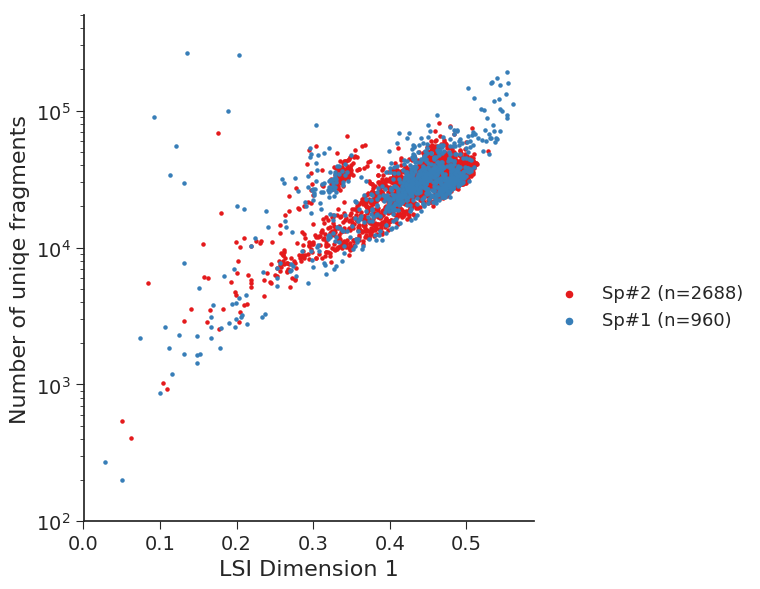

In [39]:
# have a look the first dimension and the uniq frags

g = sns.FacetGrid(plate_qc, hue='batch', size=6)
g.map(plt.scatter, 'LSI Dimension 1', 'uniq_frags', s=5)
g.ax.legend(bbox_to_anchor=[1.5, .5])
g.ax.set_yscale('log')
g.ax.set_ylim(1e2, 5e5)
g.ax.set_ylabel('Number of uniqe fragments')

plt.savefig('figures/LSI_1st_dimension_vs_uniq_frags.pdf',
            bbox_inches='tight', transparent=True)

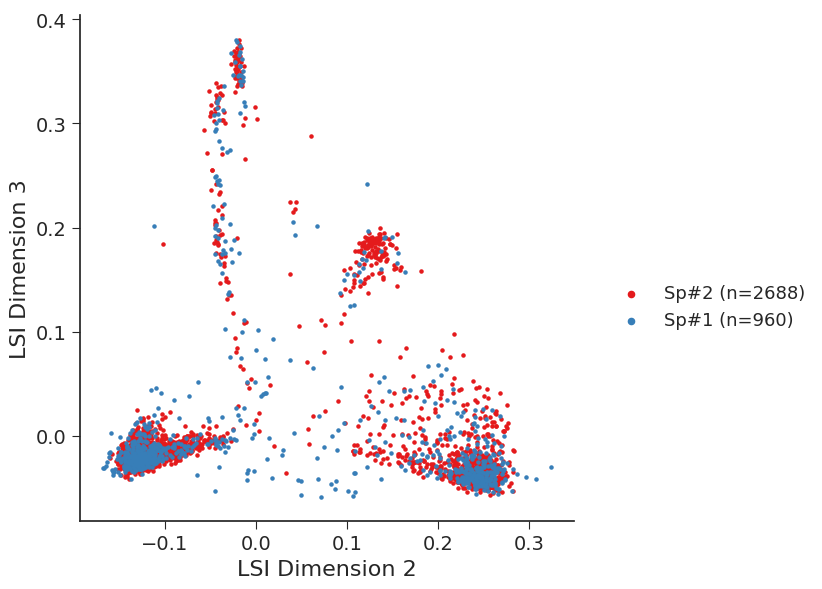

In [40]:
g = sns.FacetGrid(plate_qc, hue='batch', size=6)
g.map(plt.scatter, 'LSI Dimension 2', 'LSI Dimension 3', s=5)
g.ax.legend(bbox_to_anchor=[1.5, .5])

In [41]:
# check peaks linked to some marker genes (by annotatePeaks.pl from the HOMER suite)

homer = pd.read_table('cmp_to_immgen/homer_annotation_spleen_union_peaks_no_black_list.txt', index_col=0)
marker_genes = ['Bcl11a', 'Bcl11b', 'Cd3e', 'Cd4',
                'Cd8a', 'Cd19', 'Ms4a1', 'Ebf1',
                'Tcf7', 'Gzma', 'Lrg1']

marker_p2g = homer[homer['Gene Name'].isin(marker_genes)]['Gene Name']
marker_count = pd.concat([sc_count, marker_p2g], axis=1, join='inner')
marker_count.head(2)

,mSp_rep7_276,mSp_rep7_267,mSp_rep7_325,mSp_rep7_270,mSp_rep7_092,mSp_rep7_291,mSp_rep7_196,mSp_rep7_347,mSp_rep7_141,mSp_rep7_079,...,mSp_rep6_110,mSp_rep6_353,mSp_rep6_174,mSp_rep6_255,mSp_rep6_250,mSp_rep6_280,mSp_rep6_046,mSp_rep6_302,mSp_rep6_019,Gene Name
spleen_uPk_17545,0,0,0,0,0,2,0,6,0,0,...,4,0,0,0,0,4,0,7,0,Bcl11a
spleen_uPk_17546,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2,0,Bcl11a


In [42]:
marker_sum = marker_count.groupby('Gene Name').sum()
marker_sum

,mSp_rep7_276,mSp_rep7_267,mSp_rep7_325,mSp_rep7_270,mSp_rep7_092,mSp_rep7_291,mSp_rep7_196,mSp_rep7_347,mSp_rep7_141,mSp_rep7_079,...,mSp_rep6_216,mSp_rep6_110,mSp_rep6_353,mSp_rep6_174,mSp_rep6_255,mSp_rep6_250,mSp_rep6_280,mSp_rep6_046,mSp_rep6_302,mSp_rep6_019
Gene Name,,,,,,,,,,,,,,,,,,,,,
Bcl11a,5,21,4,0,6,35,0,32,4,0,...,3,42,16,9,4,0,30,0,42,2
Bcl11b,17,0,0,11,0,0,18,0,0,30,...,0,0,0,0,18,15,0,8,0,15
Cd19,0,2,2,0,4,5,0,5,0,0,...,0,8,2,0,0,0,12,0,6,0
Cd3e,10,0,0,4,0,2,2,2,0,6,...,0,0,0,0,5,0,0,0,0,0
Cd4,2,2,0,0,0,0,9,0,0,2,...,0,0,1,0,0,0,0,1,0,2
Cd8a,13,0,0,12,0,0,1,0,0,0,...,0,0,0,0,4,0,0,0,0,6
Ebf1,0,11,2,0,0,40,0,18,4,0,...,2,16,3,0,0,0,37,0,16,0
Gzma,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lrg1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
for g in marker_genes:
    plate_qc[g] = marker_sum.loc[g]

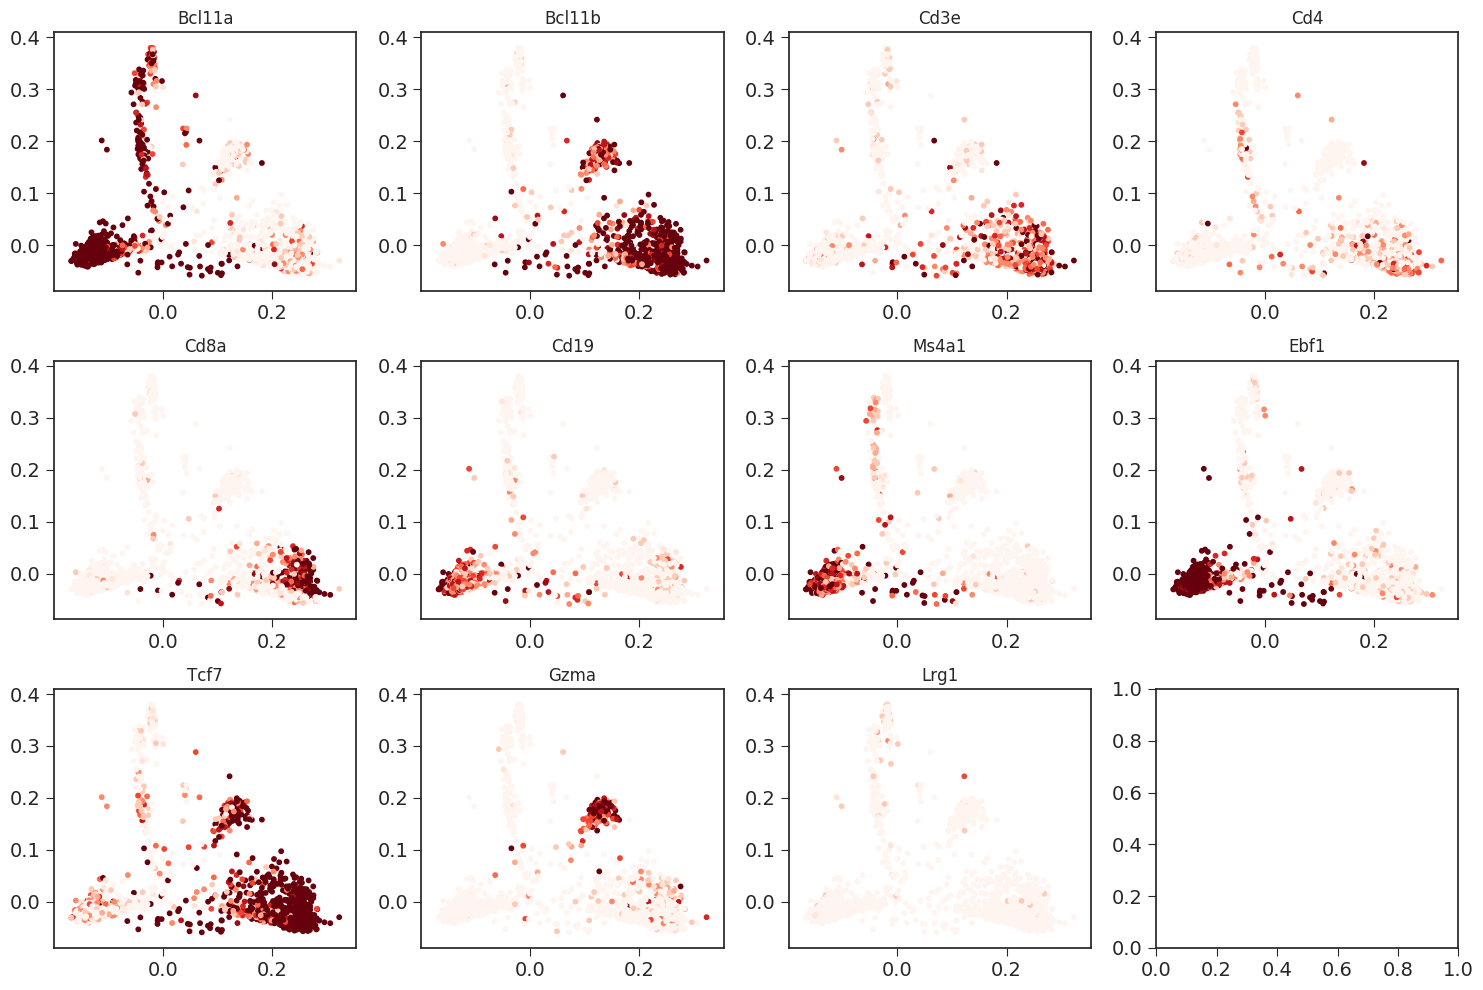

In [44]:
fig, ax = plt.subplots(figsize=(15, 10), ncols=4, nrows=3)
ax = ax.flatten()

for i, j in enumerate(marker_genes):
    ax[i].scatter(plate_qc['LSI Dimension 2'], plate_qc['LSI Dimension 3'],
                  cmap='Reds', c=plate_qc[j], vmin=0, vmax=10, s=10)
    ax[i].set_title(j, fontsize=12)

plt.tight_layout()
plt.show()

(0.5, 2.5)

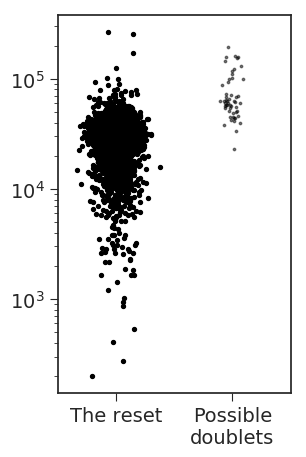

In [45]:
# some cells showed high counts around both T-cell and B-cell markers
# these are possible doublets
# if this is the case, they might have more reads/fragments than the others

tcf7_high = marker_sum.columns[marker_sum.loc['Tcf7'] > 10]
ebf1_high = marker_sum.columns[marker_sum.loc['Ebf1'] > 10]
bcl11a_high = marker_sum.columns[marker_sum.loc['Bcl11a'] > 10]
bcl11b_high = marker_sum.columns[marker_sum.loc['Bcl11b'] > 10]

dbs1 = (set(tcf7_high) & set(ebf1_high))
dbs2 = (set(bcl11a_high) & set(bcl11b_high))
dbs = dbs1 | dbs2

fig, ax = plt.subplots(figsize=(3,5))

offset1 = np.random.normal(scale=0.1, size=plate_qc.drop(labels=dbs).shape[0])
ax.scatter(1 + offset1, plate_qc.drop(labels=dbs).uniq_frags, s=8, c='k')

offset2 = np.random.normal(scale=0.05, size=len(dbs))
ax.scatter(2 + offset2, plate_qc.loc[dbs].uniq_frags, s=3, c='k', alpha=.5)
ax.set_yscale('log')

ax.set_xticks(range(1,3))
ax.set_xticklabels(['The reset', 'Possible\ndoublets'])
ax.set_xlim(0.5,2.5)

In [46]:
len(dbs)

53

In [47]:
plate_qc.loc[dbs].to_csv('mSp_scATAC-seq/qc_possible_doublets.csv')

In [48]:
plate_qc.drop(labels=dbs, inplace=True)

# Generate some other experimental figures

In [7]:
# get the size - migration time of the ladder from bioanalzyer trace

ladder_info = pd.read_csv('bioanalyzer_results/Ladder.csv', encoding = 'ISO-8859-1')
ladder_info.head(2)

,Size [bp],Conc. [pg/µl],Molarity [pmol/l],Observations,Area,Aligned Migration Time [s],Peak Height,Peak Width,% of Total,Time corrected area
0,35,125,"5,411.30",Lower Marker,160.3,43.00,98.1,1.1,0,160.3
1,50,150,"4,545.50",Ladder Peak,210.2,45.31,139.0,1.8,0,210.2


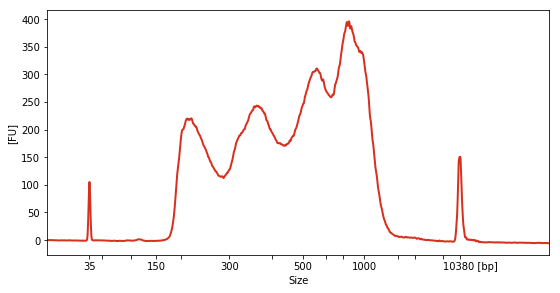

In [8]:
# plot bioanlayzer traces of each library

fig, ax = plt.subplots(figsize=(9,4.5))

samples = iglob('bioanalyzer_results/Rep*.csv')

for s in samples:
    ax.cla()
    sn = s.split('/')[-1][:-4]
    df = pd.read_csv(s, skiprows=17)
    df = df.iloc[:-1,:]
    df = df.astype(float)
    ax.plot(df.Time, df.Value, color='#d7301f', lw=2.)
    ax.set_xticks(ladder_info['Aligned Migration Time [s]'])
    ax.set_xticklabels(['35', '', '', '150', '', '300', '', '500', '', '',
                        '1000', '', '', '', '       10380 [bp]'])
    ax.set_xlim(35, 130)
    ax.set_xlabel("Size")
    ax.set_ylabel('[FU]')
    plt.savefig('figures/{}_bioanlayzer.pdf'.format(sn), bbox_inches='tight', transparent=True)